# Chapter 4. Under the Hood: Training a Digit Classifier

In [1]:
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

In [2]:
from torch.utils.data import TensorDataset

## 1. Baseline binary digit classifier 3 vs. 7
*Practicing PyTorch and build a simple classifier based on similarity with two typical digits.*

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [4]:
def load_digit(set, d):
    files = (path/set/d).ls()
    display(Image.open(files[0]))
    tensors = [tensor(Image.open(f)) for f in files]
    return torch.stack(tensors).float() / 255

In [5]:
tensors3 = load_digit('train', '3')
tensors7 = load_digit('train', '7')
tensors3.shape, tensors7.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

<AxesSubplot:>

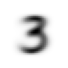

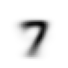

In [6]:
mean3 = tensors3.mean(0)
mean7 = tensors7.mean(0)
show_image(mean3)
show_image(mean7)

In [7]:
def dist(a, b):
    # a, b can have different ranks, broadcasting
    return (a - b).abs().mean((-1, -2))

def is3(x):
    return dist(x, mean3) < dist(x, mean7)

In [8]:
is3(tensors3[0]), is3(tensors7[0])

(tensor(True), tensor(False))

### Compute accuracy for the validation set

In [9]:
valid_tensors3 = load_digit('valid', '3')
valid_tensors7 = load_digit('valid', '7')
valid_tensors3.shape, valid_tensors7.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [10]:
acc3 = is3(valid_tensors3).float().mean()
acc7 = 1 - is3(valid_tensors7).float().mean()
acc3, acc7, (acc3 + acc7) / 2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## 2. SGD

### Mapping to a ML problem
- Each position in an image contributes to the classification decision. For instance, pixels at the bottom right corners mean it's less likely that the image is a 7. We can consider each position as a **weight**.
- The intensity of each pixel also contributes.
- We can compute some value based on these two elements that can be used to help the classification. And we want to find the weights so that the computed values can be used to classify as accurate as possible.

### Process
1. Initialize the weights.
1. For each image, use these weights to predict whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its loss).
1. Calculate the gradient, which measures for each weight, how changing that weight would change the loss
1. Step (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and repeat the process.
1. Iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer).

In [11]:
def create_dl(tensors3, tensors7, bs=256, shuffle=False):
    X = torch.cat([tensors3, tensors7]).view(-1, 28*28)
    y = tensor([1.0] * len(tensors3) + [0.0] * len(tensors7)).unsqueeze(1)
    print(X.shape, y.shape)
    ds = TensorDataset(X, y)
    dl = DataLoader(ds, bs=bs, shuffle=shuffle)
    return dl

In [12]:
dl = create_dl(tensors3, tensors7, bs=256, shuffle=True)
valid_dl = create_dl(valid_tensors3, valid_tensors7, bs=256, shuffle=False)

torch.Size([12396, 784]) torch.Size([12396, 1])
torch.Size([2038, 784]) torch.Size([2038, 1])


In [13]:
def linear(xb):
    return xb@weights + bias

def validate_epoch(model):
    all_preds = []
    all_targets = []
    for xb, yb in valid_dl:
        all_preds.append(model(xb).sigmoid())
        all_targets.append(yb)
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    return ((all_preds > 0.5) == all_targets).float().mean().item()

### Implementing the process from scratch

In [14]:
# 1. Initialize the weights
weights = torch.randn((28 * 28, 1), requires_grad=True)
bias = torch.randn(1, requires_grad=True)
lr = 1
epochs = 10

for epoch in range(epochs):
    # Train
    for xb, yb in dl:
        # 2. Forward pass, compute predictions
        preds = xb@weights + bias
        
        # 3. Compute loss
        preds = preds.sigmoid().clamp(1e-6, 1 - 1e-6)
        loss = (-yb*torch.log(preds) - (1-yb)*torch.log(1-preds)).mean()
        
        # 4. Compute gradients
        loss.backward()
        
        # 5. Update weights
        with torch.no_grad():
            for p in [weights, bias]:
                p -= p.grad * lr
                p.grad.zero_()

    # Validation     
    print(f'{validate_epoch(linear):.3f}')

0.964
0.971
0.970
0.976
0.976
0.976
0.978
0.981
0.979
0.981


### Implementing the process with PyTorch classes

Simplify:
1. Use `nn.Linear` which does both weights initialization (Step 1) and linear transformation (Step 2).
1. Use `nn.BCEWithLoss` as a loss function (Step 3)
1. Use an optimizer `torch.optim.SGD` which handles step and zero grad (Step 4 and 5).

In [15]:
# 1. Initialize the weights
linear_model = nn.Linear(28 * 28, 1)
optimizer = torch.optim.SGD(linear_model.parameters(), lr=1)
epochs = 10

for epoch in range(epochs):
    # Train
    for xb, yb in dl:
        # 2. Forward pass, compute predictions
        preds = linear_model(xb)
        
        # 3. Compute loss
        loss = nn.BCEWithLogitsLoss()(preds, yb)
        
        # 4. Compute gradients
        loss.backward()
        
        # 5. Update weights
        optimizer.step()
        optimizer.zero_grad()

    # Validation     
    print(f'{validate_epoch(linear_model):.3f}')

0.974
0.979
0.981
0.981
0.980
0.982
0.982
0.981
0.982
0.981


### Wrapping up in a fastai learner class
fastai provides a class to encapsulate the training process. Besides a standard model architecture, a loss function and an optimizer, it requires two extra pieces for validation:
- a `DataLoaders` instance which simply combines train and validation standard data loaders 
- a list of metrics to compute for the validation set at the end of each epoch.

In [16]:
dls = DataLoaders(dl, valid_dl)

In [17]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [18]:
learn = Learner(dls, nn.Linear(28*28, 1), loss_func=nn.BCEWithLogitsLoss(), opt_func=SGD, metrics=batch_accuracy)
learn.fit(10, lr=1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.078729,0.067074,0.977920,00:00
1,0.059303,0.061922,0.978901,00:00
2,0.051856,0.061686,0.979882,00:00
3,0.046706,0.055486,0.980373,00:00
4,0.043323,0.054798,0.980864,00:00
5,0.040702,0.054416,0.979882,00:00
6,0.039523,0.054839,0.981354,00:00
7,0.037756,0.051930,0.981845,00:00
8,0.036168,0.051740,0.981845,00:00
9,0.037250,0.059670,0.979882,00:00


## 3. Deep neural networks

With the basics above, it's easy to extend the linear model to a (deep) neural network. The only change required is the forward pass in Step 2.

In [19]:
deep_net = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

learn = Learner(dls, deep_net, loss_func=nn.BCEWithLogitsLoss(), opt_func=SGD, metrics=batch_accuracy)
learn.fit(20, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.688396,0.680210,0.814524,00:00
1,0.628947,0.426033,0.965162,00:00
2,0.293682,0.076844,0.971050,00:00
3,0.141844,0.063936,0.975957,00:00
4,0.083077,0.054872,0.981845,00:00
5,0.055967,0.050906,0.983808,00:00
6,0.044502,0.056580,0.980864,00:00
7,0.038228,0.048978,0.984298,00:00
8,0.035326,0.049020,0.983808,00:00
9,0.031858,0.045506,0.985770,00:00


With a DNN, choosing a large learning rate is unstable. With my 4-layer DNN, setting `lr=1` sometimes gives above 99% but sometimes 50%. Setting a small `lr=0.1` and train for a larger number of epochs gives a more consistent result.